# Import Libraries

In [1]:
%matplotlib inline
from copy import deepcopy
from matplotlib.patches import Rectangle
import natsort as ns
from multiprocessing import cpu_count
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *
import sys

from sklearn import decomposition
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1481502426928048234
]


In [2]:
# Meta-Parameters
class_to_remove = 1
base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
#base_dir = '/home/cyrilwendl'  # for GCE
#base_dir = '/raid/home/cwendl'  # for guanabana

sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package

# custom libraries
from density_tree.density_forest import *

# Load Images

In [3]:
path = os.getcwd()

im_dir = r'' + path + '/Zurich_dataset/images_tif/'
gt_dir = r'' + path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

imgs = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])

# histogram stretching
imgs_eq = imgs_stretch_eq(imgs)
imgs = imgs_eq  # continue using stretched image

images: 20 
ground truth images: 20 


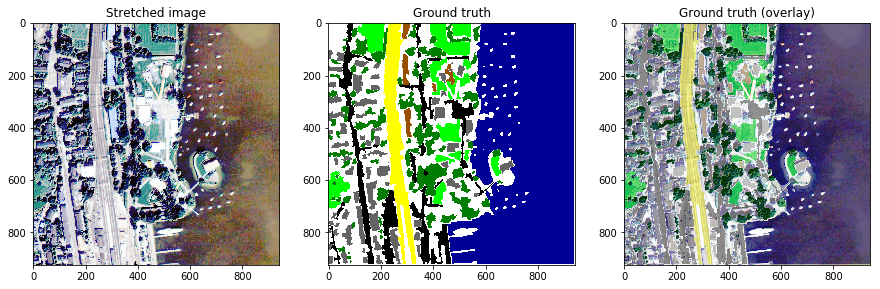

In [4]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 2
alpha=.6
overlay = imgs_eq[i][:, :, :3] * alpha + gt[i] / 255 * (1-alpha)

# TODO don't stretch image

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs[i][..., :3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [5]:
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)
    
gt_maj_label = gt_color_to_label(gt, colors)

100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


In [6]:
# Load Images
def flatten(l):
    return [item for sublist in l for item in sublist]


flat_labels = flatten(flatten(gt_maj_label))
print("Unique Labels in GT: ", np.unique(flat_labels))
print(np.shape(gt_maj_label))
gt = gt_maj_label

Unique Labels in GT:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
(20,)


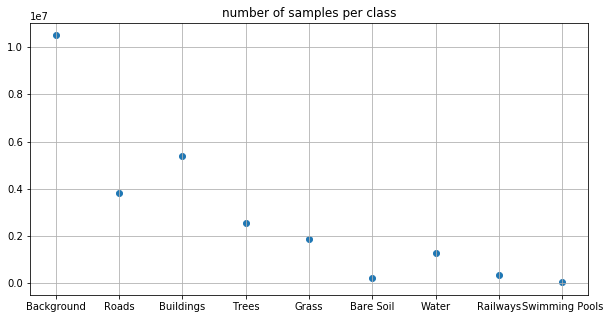

In [7]:
# print some statistics for the class distribution
unique, counts = np.unique(flat_labels, return_counts=True)
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(unique, counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

## Get patches

In [8]:
# Get patches

patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)
print(y_test_nostride.shape)

100%|██████████| 4/4 [00:00<00:00, 127.79it/s]

(3902, 64, 64, 4)
(964, 64, 64, 4)
(964, 64, 64)


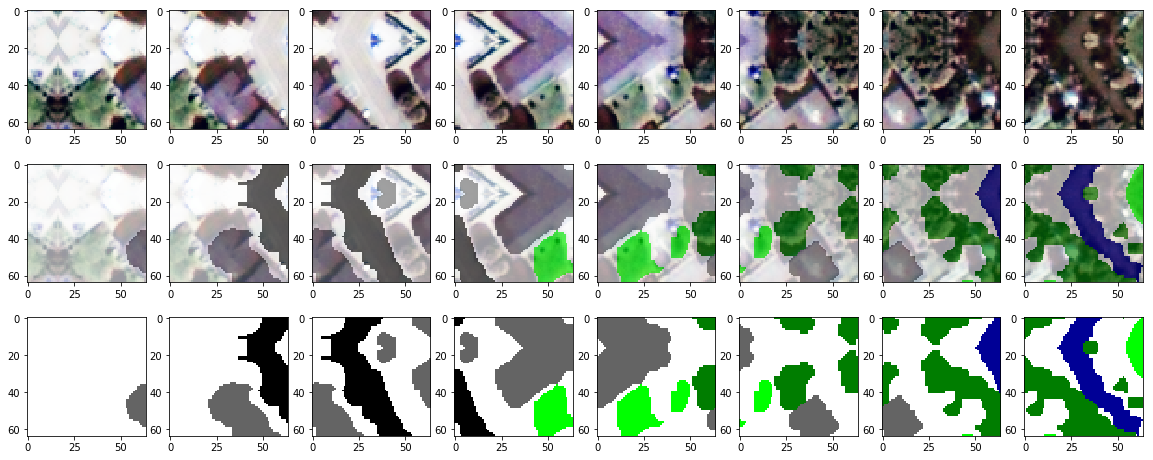

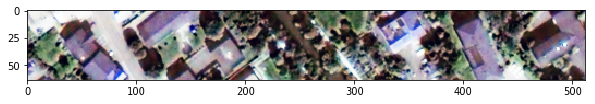

In [9]:
# visualize some patches 
imgs_row = 8
fig, axes = plt.subplots(3, imgs_row)
fig.set_size_inches(20, 8)
offset = 0
alpha = .6
for i in range(offset, offset + imgs_row):
    axes[0][i - offset].imshow(x_test[i][..., :3])  # images
    axes[1][i - offset].imshow(
        gt_label_to_color(y_test[i], colors) * alpha + x_test[i][..., :3] * (1 - alpha))  # ground truth (overlay)
    axes[2][i - offset].imshow(gt_label_to_color(y_test[i], colors))  # ground truth
    
# corresponding part of image
plt.figure(figsize=(10, 5))
plt.imshow(imgs[16][:64, :64 * 8, :3])

# Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [10]:
# create copies of original data
x_train_patches = x_train.copy()
x_val_patches = x_val.copy()
x_test_patches = x_test.copy()

y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [11]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [12]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train_patches)
x_val = np.asarray(x_val_patches)
x_test = np.asarray(x_test_patches)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])


names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("class to remove: " + str(names[class_to_remove]))
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

class to remove: Roads
classes to keep: ['Buildings', 'Trees', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


## Train CNN

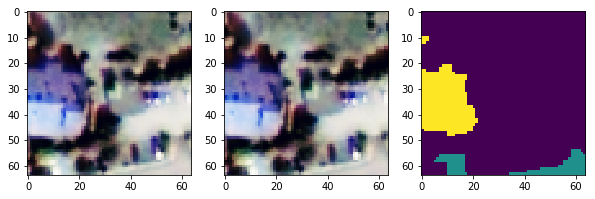

In [13]:
# data augmentation
img_idx = 14
im_patches_vis, gt_patches_vis = augment_images_and_gt(x_train_patches[img_idx], y_train_label[img_idx], rf_h=True,
                                                       rf_v=True, rot=True)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches((10, 5))
axes[0].imshow(x_train_patches[img_idx][..., :3])
axes[1].imshow(im_patches_vis[..., :3])
axes[2].imshow(gt_patches_vis)
plt.show()

In [14]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator_dev(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   # callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

Instructions for updating:
Use the retry module or similar alternatives.


<Figure size 432x288 with 0 Axes>

In [15]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)

# save the model
#model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5')  # save model, weights
model_unet = load_model(path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5',
                        custom_objects={'fn': ignore_background_class_accuracy(0)})

# Prediction on Test Set

In [ ]:
# Prediction

# get prediction
y_pred_overlap = model_unet.predict(x_test, batch_size=20, verbose=1)

 300/3902 [=>............................] - ETA: 2:08

In [ ]:
# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred_overlap, ids_test, 64, 32))

In [ ]:
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# Get accuracy as margin between highest and second highest class
y_pred_acc = get_accuracy_probas(y_pred)

In [ ]:
# plot prediction results
im_idx = 15
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_test[im_idx][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_test_label[im_idx], colors)
fig_pred = gt_label_to_color(y_pred_label[im_idx], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = np.asarray([n for n, c in legend_data])
axes[5].legend(handles, labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.colorbar()

In [ ]:
y_pred_im = [
    convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=16, patch_size=64,
                             stride=64) for i in ids_test]

_, axes = plt.subplots(1, 2, figsize=(20, 15))
img_idx = 16
axes[0].imshow(y_pred_im[img_idx-16])  # prediction
axes[1].imshow(gt_label_to_color(gt[img_idx],colors))  # gt stitched together
[axes[i].set_title(["prediction", "gt", "image"][i]) for i in range(2)]
plt.show()

# show also original image
plt.figure(figsize=(7, 7))
plt.imshow(imgs[img_idx][:, :, :3])
plt.title("original image")
plt.show()

# Accuracy Metrics (Test Set)

In [ ]:
# Accuracy metrics
y_pred_flattened= np.asarray(flatten(flatten(y_pred_label))).astype('int')
y_test_flattened= np.asarray(flatten(flatten(y_test_nostride))).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

In [ ]:
# Class accuracy, average accuracy
print(metrics.classification_report(
    y_pred_flattened[filter_items],
    y_test_flattened[filter_items],
    target_names=np.asarray(labels)[classes_to_keep],
    digits=3))

# Overall accuracy
OA = metrics.accuracy_score(y_pred_flattened[filter_items], y_test_flattened[filter_items])
print("Overall accuracy: %.3f" % OA)

# Certainty using Density Forest

In [ ]:
from keras import backend as k

# image, layer indexes
layer_idx = -2
img_idx = 2
batch_size = 20

# get activations for training Density Forest

In [ ]:
act_train = get_activations(imgs, model_unet, layer_idx, x_train, ids_train, batch_size=80,
                                  patch_size=64, stride=64, n_filters=32)

In [ ]:
# get activations for unseen class
filter_unseen = (y_train_label != 0) & (y_train_label == class_to_remove)
act_unseen = np.concatenate(act_train)[filter_unseen]

# retain only activation weights for which there is a ground truth
filter_seen = (y_train_label != 0) & (y_train_label != class_to_remove)
act_seen = np.concatenate(act_train)[filter_seen]

del act_train

In [ ]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=15)
pca.fit(act_seen)
n_components = np.alen(pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_) < .95]) + 1
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_[:n_components])))

pca = decomposition.PCA(n_components=n_components)
pca.fit(act_seen)

act_seen = pca.transform(act_seen)
act_unseen = pca.transform(act_unseen)

# validation label
y_seen_1D = y_train_label[filter_seen]

plt.cla()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.show()

In [ ]:
# get activations for testing Density Forest
act_test = get_activations(imgs, model_unet, layer_idx, x_test, ids_test, batch_size=80, 
                                  patch_size=64, stride=32, n_filters=32)

# remove test activations overlap
act_test_no_overlap = remove_overlap(imgs, np.concatenate(act_test), ids_test, patch_size=64, stride=32) 

In [ ]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[...,np.newaxis],
                                       img_idx=idx_im, img_start=idx_im, patch_size=64,
                                       stride=64) for idx_im in ids_test]

In [ ]:
act_test = np.concatenate(act_test_no_overlap, axis=0)[y_test_nostride < np.infty]
act_test = pca.transform(act_test)

In [ ]:
# plot PCA points

# get data subset to show in figure
n_points = 500
dataset_indices = np.arange(len(act_seen))

#  draw random samples with replacement
dataset_subset_indices = np.random.choice(dataset_indices, size=n_points, replace=True, )
dataset_subset = act_seen[dataset_subset_indices, :]

dataset_indices = np.arange(len(act_unseen))
dataset_subset_indices_unseen = np.random.choice(dataset_indices, size=int(n_points/9), replace=True, )


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=Axes3D.name)
for class_keep in classes_to_keep:
    plot_data = act_seen[dataset_subset_indices][y_seen_1D[dataset_subset_indices] == class_keep]
    plot_color = y_seen_1D[dataset_subset_indices][y_seen_1D[dataset_subset_indices] == class_keep]
    ax.scatter(plot_data[:, 0], plot_data[:, 1], zs=plot_data[:, 2], c=np.asarray(colors)[class_keep]/255, s=15,
               depthshade=True, marker='o')

ax.scatter(act_unseen[dataset_subset_indices_unseen, 0], act_unseen[dataset_subset_indices_unseen, 1],
           zs=act_unseen[dataset_subset_indices_unseen, 2], c=np.asarray(colors)[class_to_remove]/255, s=20, marker='x', depthshade=True)
names_legend = names_keep.copy()
names_legend.append('unseen class (' + names[class_to_remove] + ')')
ax.legend(names_legend, ncol=2)
plt.savefig("../Figures/pca_components_3d_"+names[class_to_remove]+".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

## Train Density Forest

In [ ]:
warnings.filterwarnings("ignore")
subset_data = 0.001
print("Number of points on which to train each tree: %i" % int(np.shape(act_seen)[0] * subset_data))
root_nodes_seen = density_forest_create(act_seen, n_classes, 10, subset_data, n_jobs=-1, verbose=10)

In [ ]:
# get probabilities for all images
n_jobs = 1
patches_start = get_offset(imgs, 64, 64, 16, 16)
patches_end = get_offset(imgs, 64, 64, 16, 20)
probas = Parallel(n_jobs=n_jobs, verbose=1)(  # try for multiprocessing
    delayed(density_forest_traverse_x)(
        act_test[patch_idx * (patch_size * patch_size):(patch_idx + 1) * (patch_size * patch_size), :],
        root_nodes_seen, thresh=.1)
    for patch_idx in range(patches_start, patches_end + 1))

In [ ]:
# reshape probas to (n_patches, patch_size, patch_size)
n_patches = patches_end - patches_start
patches_start = get_offset(imgs, 64, 64, 16, 16) # idx of first patch in image
patches_end = get_offset(imgs, 64, 64, 16, 20) # idx of first patch in image
n_patches = patches_end-patches_start
probas_seen_im = np.reshape(np.asarray(probas[:-1]), (n_patches,patch_size,patch_size))

# save probabilities corresponding to an image in an array
probas_imgs = [] # (n_imgs, n_patches, patch_size, patch_size)
for idx_im in ids_test:
    patches_start = get_offset(imgs, 64, 64, 16, idx_im) # idx of first patch in image
    patches_end = get_offset(imgs, 64, 64, 16, idx_im+1) # idx of last patch in image
    probas_im = np.asarray(probas_seen_im[patches_start:patches_end])
    probas_imgs.append(probas_im)

In [ ]:
# plot prediction results with new uncertainty
#  %matplotlib inline

idx_offset = get_offset(imgs, 64, 64, 16, idx_im)
idx_patch = 20
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_test_nostride[idx_offset + idx_patch][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_test_nostride[idx_offset + idx_patch], colors)
fig_pred = gt_label_to_color(y_pred_label[idx_offset + idx_patch], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = [n for n, c in legend_data]
axes[5].legend(handles, labels)

# show certitude by network
im_overlay = get_fig_overlay(fig_im, probas_imgs[idx_im-16][idx_patch], thresh=.93, opacity=.4)
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14, 6)
f1 = axes[0].imshow(y_pred_acc[idx_offset + idx_patch], cmap='gray')
fig.colorbar(f1, ax=axes[0], orientation='horizontal')
f2 = axes[1].imshow(probas_imgs[idx_im-16][idx_patch], cmap='gray')
fig.colorbar(f2, ax=axes[1], orientation='horizontal', spacing='proportional')
axes[0].set_title("Network Confidence")
axes[1].set_title("Density Forest")
axes[2].imshow(im_overlay)
plt.show()

In [ ]:
# convert patches to image
idx_im = 19


# show certitude by network
# image, overlay
from ipywidgets import interact, FloatSlider
def fig_uncertainty(thresh, save=False, show=True):
    
    im_overlay = get_fig_overlay(imgs[idx_im][:im_cert_out.shape[0],:im_cert_out.shape[1],:3],im_cert_out[...,0],
                             thresh=thresh,opacity=.5)

    fig = plt.figure(figsize=(8,8))
    plt.imshow(im_overlay)
    if save:
        plt.savefig("../Figures/confidence_thresh_" + 
                    str(names[class_to_remove]).lower() + 
                    '_im_' + str(idx_im+1) + "_tr_" + str(thresh) +".pdf", bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    
#interact(fig_uncertainty,thresh=(1e-6,1e-4,1e-6))
for idx_im in ids_test:
    im_cert_out = convert_patches_to_image(imgs, probas_imgs[idx_im-16][..., np.newaxis],
                                       img_idx=idx_im, patch_size=64,
                                       stride=64, img_start=idx_im)
    for thresh in [1e-6,1e-5,1e-4]:

        fig_uncertainty(thresh, save=True, show=False)

fig, axes = plt.subplots(1,2,figsize=(16, 16))
axes[0].imshow(im_cert_out[..., 0], cmap='gray')
axes[1].imshow(y_pred_acc_imgs[idx_im-16][...,0],cmap='gray')

axes[0].set_title("Density Forest Confidence")
axes[1].set_title("Network Confidence")
plt.show()

In [ ]:
# calculate average certainty for all classes over all test images

probas_patches = np.concatenate(probas_imgs) # all patches concatenated (like y_test)
av_cert = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(probas_patches[y_test_nostride==label]))
av_cert = np.asarray(av_cert)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f" % (names[idx + 1], w))

# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

print("Average certainty seen class:\t\t%.4f" % cert_unseen)
print("Average certainty unseen classes:\t%.4f" % cert_seen)
print("Ratio seen class / unseen classes:\t%.4f" % (cert_seen / cert_unseen))

Certitude over test images

Class left out | Number of Components kept in PCA | Ratio certainty seen classes / unseen class
--- | --- | ---
Roads | 5 | 4.709
Buildings| 4 | 3.802
Trees| 5 | 0.9477
Grass| x | x
Bare Soil| x | x
Water| x | x
Railways| x | x
Swimming Pools| x | x